In [ ]:
from joblib import load
from pathlib import Path

from fastai.tabular.core import cont_cat_split, TabularPandas, Categorify
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics

## Load data

In [ ]:
path = Path('.')
data_path = path / 'data'
models_path = path / 'models'
model_preds_path = path / 'model_preds'

In [ ]:
test_xs = pd.read_pickle(data_path/'test_xs.pkl')
test_y = pd.read_pickle(data_path/'test_y.pkl')
weights = pd.read_pickle(data_path/'weights.pkl')

In [ ]:
test_indices = test_xs.index
test_frac = 0.1

In [ ]:
fname = 'data_xs.pkl'
if (data_path/fname).exists():
    data_xs = pd.read_pickle(data_path/fname)
    print(f'{fname} loaded')
else:
    df = pd.read_pickle('df.pkl')
    df_data = df[df['channel']=='data'].copy()
    del df
    df_data.drop(columns=['channel', 'weight'], inplace=True)
    Z_MASS = 91.1876
    if 'zdiff' not in df_data.columns: 
        df_data.insert(1, 'zdiff', abs(df_data['mLL'] - Z_MASS))
    cont, cat = cont_cat_split(df_data)
    procs = [Categorify]
    to = TabularPandas(df_data, procs=procs, cont_names=cont, cat_names=cat)
    data_xs = to.train.xs
    data_xs.to_pickle(data_path/fname)
    print('{fname} saved')

data_xs.pkl loaded


## DT

In [ ]:
clf1 = load(models_path/'best_dt.joblib')

In [ ]:
test_preds = clf1.predict_proba(test_xs)

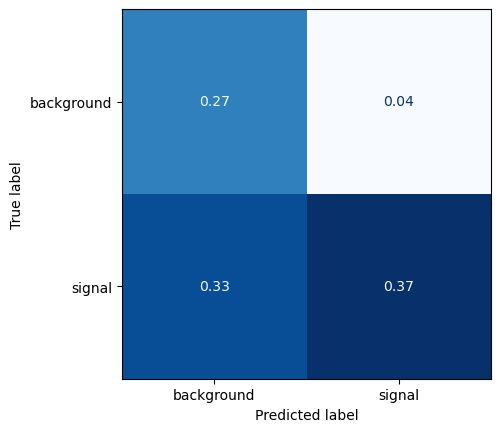

In [ ]:
cm = metrics.ConfusionMatrixDisplay.from_estimator(clf1, test_xs, test_y, 
                                           sample_weight=weights[test_indices],
                                           cmap='Blues', display_labels=['background', 'signal'], 
                                           colorbar=False, values_format='.2f', normalize='all')

In [ ]:
print(f'#signals / #backgrounds: {cm.confusion_matrix[1, 1] / cm.confusion_matrix[0, 1]:.2f}')
print(f'precision: {cm.confusion_matrix[1, 1] / (cm.confusion_matrix[1, 1] + cm.confusion_matrix[0, 1]):.3f}')
print(f'#signals: {cm.confusion_matrix[1, 1]:.3f}')

#signals / #backgrounds: 10.51
precision: 0.913
#signals: 0.369


In [ ]:
# Get the predictions for the elements corresponding to y==0
test_preds_bkg = test_preds[test_y == 0][:,0]
test_preds_sig = test_preds[test_y == 1][:,1]

In [ ]:
weights_bkg = weights[test_indices][test_y == 0]
weights_sig = weights[test_indices][test_y == 1]

In [ ]:
data_preds = clf1.predict_proba(data_xs)

<matplotlib.legend.Legend>

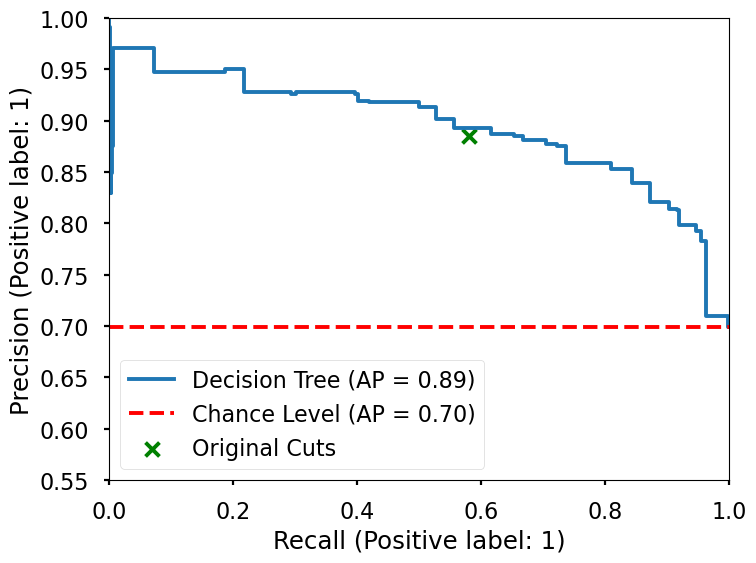

In [ ]:
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(8, 6))

display = metrics.PrecisionRecallDisplay.from_estimator(clf1, test_xs, test_y, name='Decision Tree', 
                                                sample_weight=weights[test_indices], ax=ax)

chance_ap = sum(weights_sig)/(sum(weights_sig)+ sum(weights_bkg))
original_cut_recall = 827.22 / (827.22 + 597.98)
original_cut_precision = 827.22 / (827.22 + 107.50)
plt.axhline(chance_ap, color='red', linestyle='--', label=f'Chance Level (AP = {chance_ap:.2f})')
plt.scatter(original_cut_recall, original_cut_precision, color='green', label='Original Cuts', s=100, marker='x')
plt.ylim(0.55, 1.0)
plt.xlim(0, 1)
# add chance level line to legend
plt.legend(loc='lower left')

<matplotlib.legend.Legend>

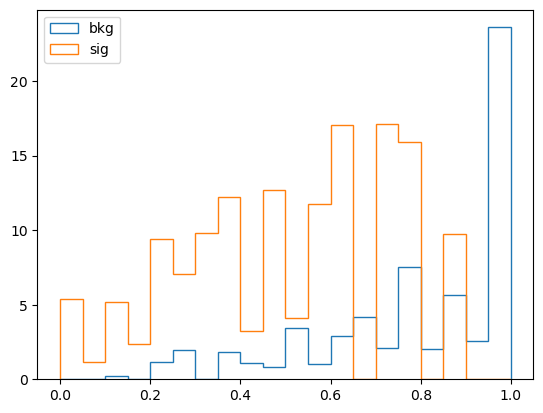

In [ ]:
plt.hist(test_preds_bkg, bins=20, range=(0, 1), histtype='step', label='bkg', weights=weights_bkg)
plt.hist(test_preds_sig, bins=20, range=(0, 1), histtype='step', label='sig', weights=weights_sig)
plt.legend(loc='upper left')

In [ ]:
prec, rec, thresh = metrics.precision_recall_curve(test_y, test_preds[:,1], sample_weight=weights[test_indices])
# find thresh which gives recall = original_cut_recall
idx = np.argmin(np.abs(rec - original_cut_recall)) - 1
print(f'original recall: {original_cut_recall:.3f}, precision: {original_cut_precision:.3f}')
print(f'dt recall: {rec[idx]:.3f}, precision: {prec[idx]:.3f}, thresh: {thresh[idx]:.3f}')

original recall: 0.580, precision: 0.885
dt recall: 0.615, precision: 0.893, thresh: 0.472


Text(0.5, 1.0, 'Adjusted threshold: 0.472')

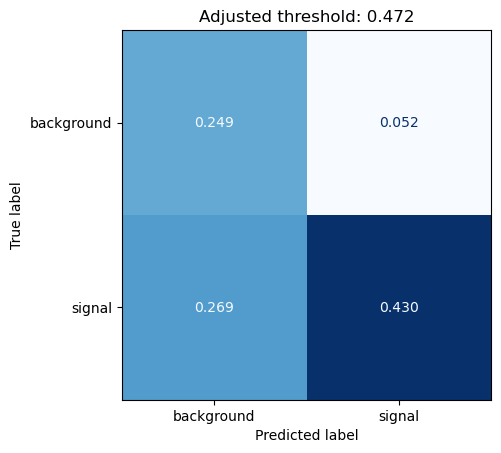

In [ ]:
plt.style.use('default')
# compute cm with adjusted threshold
adj_preds = test_preds[:,1] >= thresh[idx]
# convert adj_preds to int
adj_preds = adj_preds.astype(int)
adj_cm = metrics.ConfusionMatrixDisplay.from_predictions(test_y, adj_preds, sample_weight=weights[test_indices],
                                           cmap='Blues', display_labels=['background', 'signal'], 
                                           colorbar=False, values_format='.3f', normalize='all')
ax = plt.gca()
ax.set_title(f'Adjusted threshold: {thresh[idx]:.3f}')

In [ ]:
print(f'precision: {adj_cm.confusion_matrix[1, 1] / (adj_cm.confusion_matrix[1, 1] + adj_cm.confusion_matrix[0, 1]):.3f}')
print(f'recall: {adj_cm.confusion_matrix[1, 1] / (adj_cm.confusion_matrix[1, 1] + adj_cm.confusion_matrix[1, 0]):.3f}')
print(f'#signals/#backgrounds: {adj_cm.confusion_matrix[1, 1] / adj_cm.confusion_matrix[0, 1]:.2f}')
print(f'#signals: {adj_cm.confusion_matrix[1, 1]:.3f}')

precision: 0.893
recall: 0.615
#signals/#backgrounds: 8.35
#signals: 0.430


In [ ]:
adj_test_preds = adj_preds
test_weights = weights[test_indices]
data_preds = clf1.predict_proba(data_xs)
adj_data_preds = data_preds[:,1] >= thresh[idx]
adj_data_preds = adj_data_preds.astype(int)

In [ ]:
# count values in adj_data_preds
print(f'#signals: {np.count_nonzero(adj_data_preds):.3f}')
print(f'#backgrounds: {len(adj_data_preds) - np.count_nonzero(adj_data_preds):.3f}')

#signals: 1038.000
#backgrounds: 1391.000


In [ ]:
np.save(model_preds_path/'dt_adj_test_preds.npy', adj_test_preds)
np.save(model_preds_path/'dt_adj_weights.npy', test_weights)
np.save(model_preds_path/'dt_adj_data_preds.npy', adj_data_preds)

## RF

In [ ]:
clf2 = load(models_path/'best_rf.joblib')

In [ ]:
test_preds = clf2.predict_proba(test_xs)

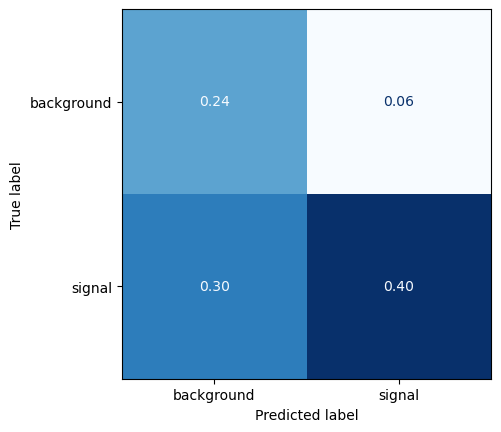

In [ ]:
plt.style.use('default')
cm = metrics.ConfusionMatrixDisplay.from_estimator(clf2, test_xs, test_y, 
                                           sample_weight=weights[test_indices]/test_frac,
                                           cmap='Blues', display_labels=['background', 'signal'], 
                                           colorbar=False, values_format='.2f', normalize='all')

In [ ]:
print(f'#signals / #backgrounds: {cm.confusion_matrix[1, 1] / cm.confusion_matrix[0, 1]:.2f}')
print(f'precision: {cm.confusion_matrix[1, 1] / (cm.confusion_matrix[1, 1] + cm.confusion_matrix[0, 1]):.3f}')
print(f'#signals: {cm.confusion_matrix[1, 1]:.3f}')

#signals / #backgrounds: 7.15
precision: 0.877
#signals: 0.401


In [ ]:
# Get the predictions for the elements corresponding to y==0
test_preds_bkg = test_preds[test_y == 0][:,0]
test_preds_sig = test_preds[test_y == 1][:,1]

In [ ]:
weights_bkg = weights[test_indices][test_y == 0]
weights_sig = weights[test_indices][test_y == 1]

In [ ]:
data_preds = clf2.predict_proba(data_xs)

In [ ]:
# numpy arrays for the CLs method
np.save(model_preds_path/'rf_test_preds_bkg.npy', test_preds_bkg)
np.save(model_preds_path/'weights_bkg.npy', weights_bkg)
np.save(model_preds_path/'rf_test_preds_sig.npy', test_preds_sig)
np.save(model_preds_path/'weights_sig.npy', weights_sig)
np.save(model_preds_path/'rf_data_preds.npy', data_preds)

Text(0.5, 0, 'Probability of belonging to the true class')

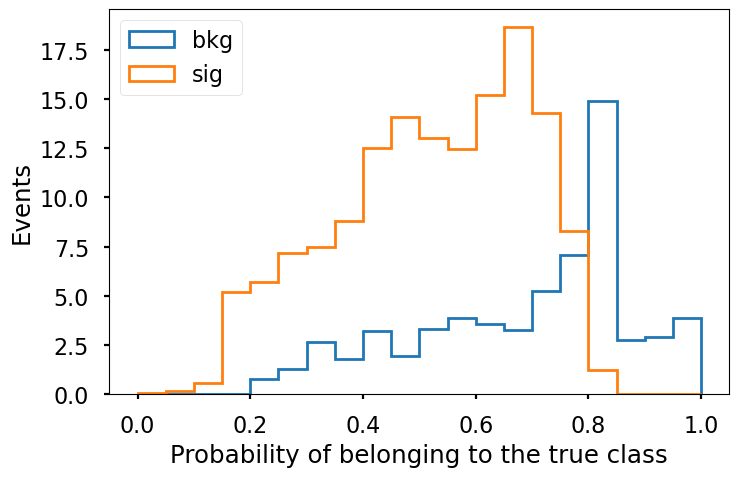

In [ ]:
plt.style.use('seaborn-v0_8-poster')
plt.figure(figsize=(8, 5))

plt.hist(test_preds_bkg, bins=20, range=(0, 1), histtype='step', label='bkg', weights=weights_bkg, linewidth=2)
plt.hist(test_preds_sig, bins=20, range=(0, 1), histtype='step', label='sig', weights=weights_sig, linewidth=2)
plt.legend(loc='upper left')
plt.ylabel('Events')
plt.xlabel('Probability of belonging to the true class')

<matplotlib.legend.Legend>

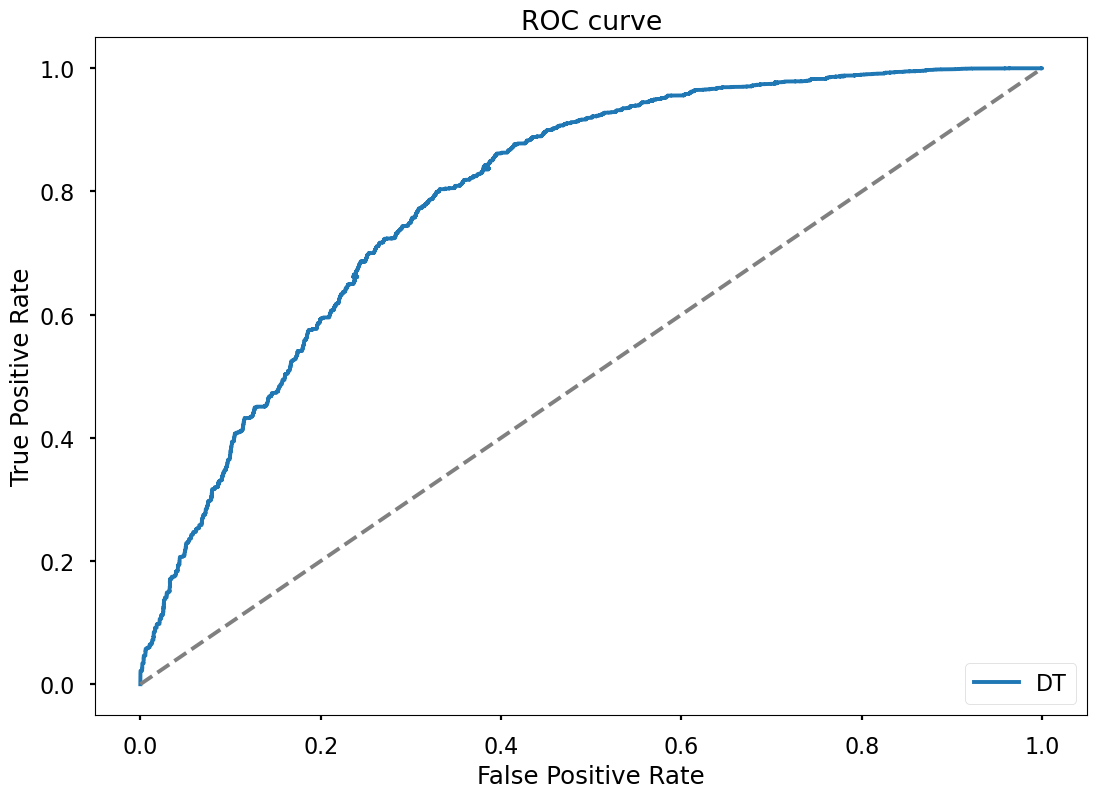

In [ ]:
# Plot the ROC curve
fig, ax = plt.subplots()
fpr, tpr, _ = metrics.roc_curve(test_y, test_preds[:,1], sample_weight=weights[test_indices])
ax.plot(fpr, tpr, label='DT')
# plot the random line
ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
ax.legend(loc='lower right')

<matplotlib.legend.Legend>

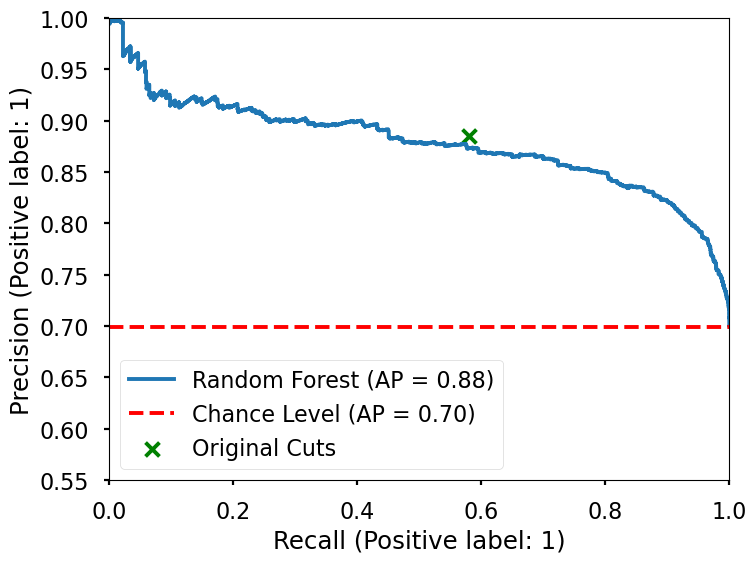

In [ ]:
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(8, 6))

display = metrics.PrecisionRecallDisplay.from_estimator(clf2, test_xs, test_y, name='Random Forest', 
                                                sample_weight=weights[test_indices], ax=ax)

chance_ap = sum(weights_sig)/(sum(weights_sig)+ sum(weights_bkg))
original_cut_recall = 827.22 / (827.22 + 597.98)
original_cut_precision = 827.22 / (827.22 + 107.50)
plt.axhline(chance_ap, color='red', linestyle='--', label=f'Chance Level (AP = {chance_ap:.2f})')
plt.scatter(original_cut_recall, original_cut_precision, color='green', label='Original Cuts', s=100, marker='x')
plt.ylim(0.55, 1.0)
plt.xlim(0, 1)
# add chance level line to legend
plt.legend(loc='lower left')

## BDT

In [ ]:
clf3 = load(models_path/'best_bdt.joblib')

In [ ]:
test_preds = clf3.predict_proba(test_xs)

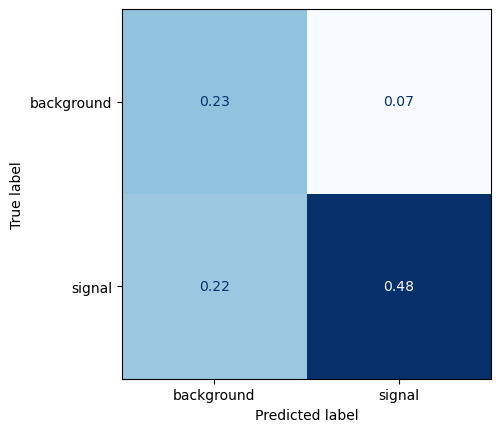

In [ ]:
plt.style.use('default')
cm = metrics.ConfusionMatrixDisplay.from_estimator(clf3, test_xs, test_y, 
                                           sample_weight=weights[test_indices]/test_frac,
                                           cmap='Blues', display_labels=['background', 'signal'], 
                                           colorbar=False, values_format='.2f', normalize='all')

In [ ]:
print(f'#signals / #backgrounds: {cm.confusion_matrix[1, 1] / cm.confusion_matrix[0, 1]:.2f}')
print(f'precision: {cm.confusion_matrix[1, 1] / (cm.confusion_matrix[1, 1] + cm.confusion_matrix[0, 1]):.3f}')
print(f'#signals: {cm.confusion_matrix[1, 1]:.3f}')

#signals / #backgrounds: 6.95
precision: 0.874
#signals: 0.476


In [ ]:
# Get the predictions for the elements corresponding to y==0
test_preds_bkg = test_preds[test_y == 0][:,0]
test_preds_sig = test_preds[test_y == 1][:,1]

In [ ]:
weights_bkg = weights[test_indices][test_y == 0]
weights_sig = weights[test_indices][test_y == 1]

In [ ]:
data_preds = clf3.predict_proba(data_xs)

Text(0.5, 0, 'Probability of belonging to the true class')

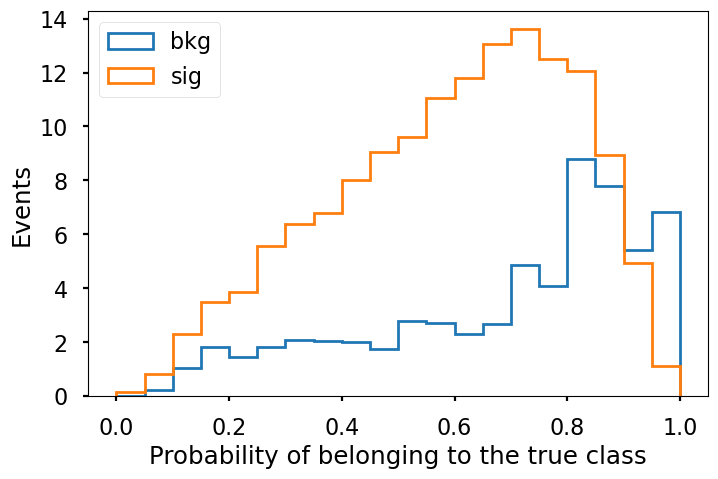

In [ ]:
plt.style.use('seaborn-v0_8-poster')
plt.figure(figsize=(8, 5))

plt.hist(test_preds_bkg, bins=20, range=(0, 1), histtype='step', label='bkg', weights=weights_bkg, linewidth=2)
plt.hist(test_preds_sig, bins=20, range=(0, 1), histtype='step', label='sig', weights=weights_sig, linewidth=2)
plt.legend(loc='upper left')
plt.ylabel('Events')
plt.xlabel('Probability of belonging to the true class')

<matplotlib.legend.Legend>

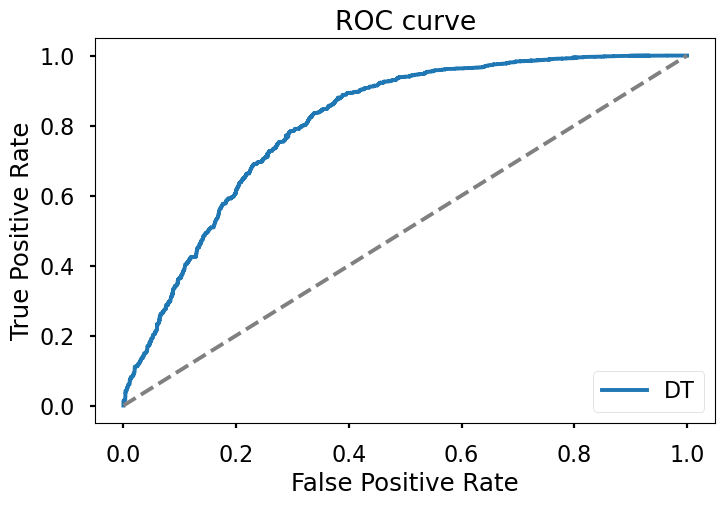

In [ ]:
plt.style.use('seaborn-v0_8-poster')
# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 5))
fpr, tpr, _ = metrics.roc_curve(test_y, test_preds[:,1], sample_weight=weights[test_indices])
ax.plot(fpr, tpr, label='DT')
# plot the random line
ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
ax.legend(loc='lower right')

<matplotlib.legend.Legend>

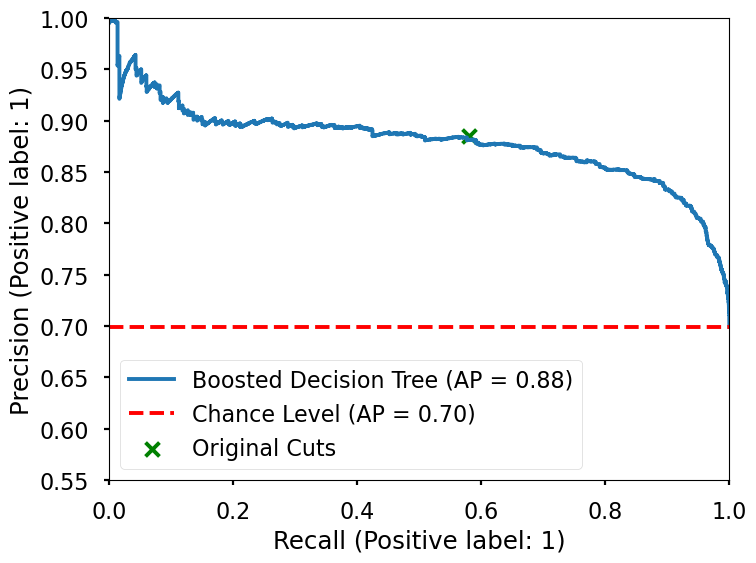

In [ ]:
plt.style.use('seaborn-v0_8-poster')
fig, ax = plt.subplots(figsize=(8, 6))

display = metrics.PrecisionRecallDisplay.from_estimator(clf3, test_xs, test_y, name='Boosted Decision Tree', 
                                                sample_weight=weights[test_indices], ax=ax)

chance_ap = sum(weights_sig)/(sum(weights_sig)+ sum(weights_bkg))
original_cut_recall = 827.22 / (827.22 + 597.98)
original_cut_precision = 827.22 / (827.22 + 107.50)
plt.axhline(chance_ap, color='red', linestyle='--', label=f'Chance Level (AP = {chance_ap:.2f})')
plt.scatter(original_cut_recall, original_cut_precision, color='green', label='Original Cuts', s=100, marker='x')
plt.ylim(0.55, 1.0)
plt.xlim(0, 1)
# add chance level line to legend
plt.legend(loc='lower left')

In [ ]:
# save numpy arrays for the CLs method
np.save(model_preds_path/'bdt_test_preds_bkg.npy', test_preds_bkg)
np.save(model_preds_path/'weights_bkg.npy', weights_bkg)
np.save(model_preds_path/'bdt_test_preds_sig.npy', test_preds_sig)
np.save(model_preds_path/'weights_sig.npy', weights_sig)
np.save(model_preds_path/'bdt_data_preds.npy', data_preds)